# Lambda Execution Log Analysis

Analysis of Lambda execution logs from S3.

**Data**: 1,950 executions from August 2025 to February 2026

In [1]:
import boto3
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

# Set plotting style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports loaded")

✓ Imports loaded


## 1. Load Data from DynamoDB (Single Source of Truth)

In [2]:
def load_lambda_logs():
    """Load all Lambda logs from DynamoDB into a pandas DataFrame."""
    dynamodb = boto3.resource('dynamodb', region_name='eu-west-1')
    table = dynamodb.Table('lambda-execution-logs')
    
    print("Loading from DynamoDB...")
    
    # Scan table (efficient for small datasets like yours)
    response = table.scan()
    logs = response.get('Items', [])
    
    # Handle pagination if needed
    while 'LastEvaluatedKey' in response:
        print(f"  Retrieved {len(logs)} so far...")
        response = table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
        logs.extend(response.get('Items', []))
    
    print(f"✓ Loaded {len(logs):,} logs from DynamoDB")
    return pd.DataFrame(logs)

# Load data
df = load_lambda_logs()
print(f"\nDataset info:")
print(f"  Rows: {len(df)}")
print(f"  Columns: {list(df.columns)}")
df.head()

Loading from DynamoDB...


✓ Loaded 2,011 logs from DynamoDB

Dataset info:
  Rows: 2011
  Columns: ['duration_ms', 'function_name', 'path', 'request_id', 'timestamp', 'memory_limit_mb', 'estimated_cost_usd']


,duration_ms,function_name,path,request_id,timestamp,memory_limit_mb,estimated_cost_usd
0,1.7,cvdev,,77867738-8a1f-488f-b30e-eb140b3e529d,2025-08-13 22:57:08.624,122.0703125,2.033776032924652099609375E-7
1,1.68,cvdev,,2664ed45-a1d5-432e-b90c-45656114e1b9,2025-08-13 22:57:08.777,122.0703125,2.0333786678314208984375E-7
2,11.12,cvdev,,ce71a891-eb08-4470-af47-aaeedf8f7b04,2025-08-14 01:27:18.934,122.0703125,2.2209349918365478515625E-7
3,1.69,cvdev,,edb67940-d1f7-48c1-9b9e-ea1905b4281b,2025-08-14 01:27:19.063,122.0703125,2.0335773503780364990234375E-7
4,1.91,cvdev,,6896bc25-82e2-4cae-be54-6010f979631b,2025-08-14 05:33:57.513,122.0703125,2.0379483664035797119140625E-7


## 2. Data Preparation

In [3]:
# Convert timestamp to datetime (handle ISO8601 format from DynamoDB)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

# Convert Decimal types from DynamoDB to float
for col in ['duration_ms', 'memory_limit_mb', 'estimated_cost_usd']:
    if col in df.columns:
        df[col] = df[col].astype(float)

# Convert costs to microdollars
df['cost_microdollars'] = df['estimated_cost_usd'] * 1_000_000

# Sort by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"Data range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Total executions: {len(df):,}")
print(f"Total cost: {df['cost_microdollars'].sum():.2f} µ$")

df.info()

Data range: 2025-08-13 22:57:08.624000 to 2026-02-09 14:58:28.841000
Total executions: 2,011
Total cost: 3979.60 µ$
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   duration_ms         2011 non-null   float64       
 1   function_name       2011 non-null   object        
 2   path                2011 non-null   object        
 3   request_id          2011 non-null   object        
 4   timestamp           2011 non-null   datetime64[ns]
 5   memory_limit_mb     2011 non-null   float64       
 6   estimated_cost_usd  2011 non-null   float64       
 7   cost_microdollars   2011 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 125.8+ KB


## 3. Basic Statistics

In [4]:
# Summary statistics
df[['duration_ms', 'memory_limit_mb', 'cost_microdollars']].describe()

,duration_ms,memory_limit_mb,cost_microdollars
count,2011.000000,2011.000000,2011.000000
mean,892.369742,122.256076,1.978916
std,1521.196564,1.033219,3.037626
min,1.290000,122.070312,0.202563
25%,10.255000,122.070312,0.220375
50%,486.440000,122.070312,1.166471
75%,898.100000,122.070312,1.991670
max,16074.690000,128.000000,32.137603


In [5]:
# Requests by path (excluding empty paths)
df_with_paths = df[df['path'] != '']
path_counts = df_with_paths['path'].value_counts()

print(f"Records with paths: {len(df_with_paths):,} / {len(df):,} ({len(df_with_paths)/len(df)*100:.1f}%)")
print(f"Records without paths: {len(df) - len(df_with_paths):,} (historical CloudWatch data)\n")

if len(path_counts) > 0:
    print("Top 10 endpoints by request count:")
    print(path_counts.head(10))
    
    # Percentage breakdown
    print("\nPercentage breakdown (of requests with paths):")
    print((path_counts / len(df_with_paths) * 100).head(10).round(1))
else:
    print("No path data available")


Records with paths: 63 / 2,011 (3.1%)
Records without paths: 1,948 (historical CloudWatch data)

Top 10 endpoints by request count:
path
/t3                               17
/contents                         14
/favicon.ico                      14
/lambda-stats                      7
/gardencam                         4
/gardencam/timelapse               3
/gardencam/videos                  2
/gardencam/timelapse/timelapse     1
/gardencam/timelapse/schedule      1
Name: count, dtype: int64

Percentage breakdown (of requests with paths):
path
/t3                               27.0
/contents                         22.2
/favicon.ico                      22.2
/lambda-stats                     11.1
/gardencam                         6.3
/gardencam/timelapse               4.8
/gardencam/videos                  3.2
/gardencam/timelapse/timelapse     1.6
/gardencam/timelapse/schedule      1.6
Name: count, dtype: float64


## 4. Time Series Analysis

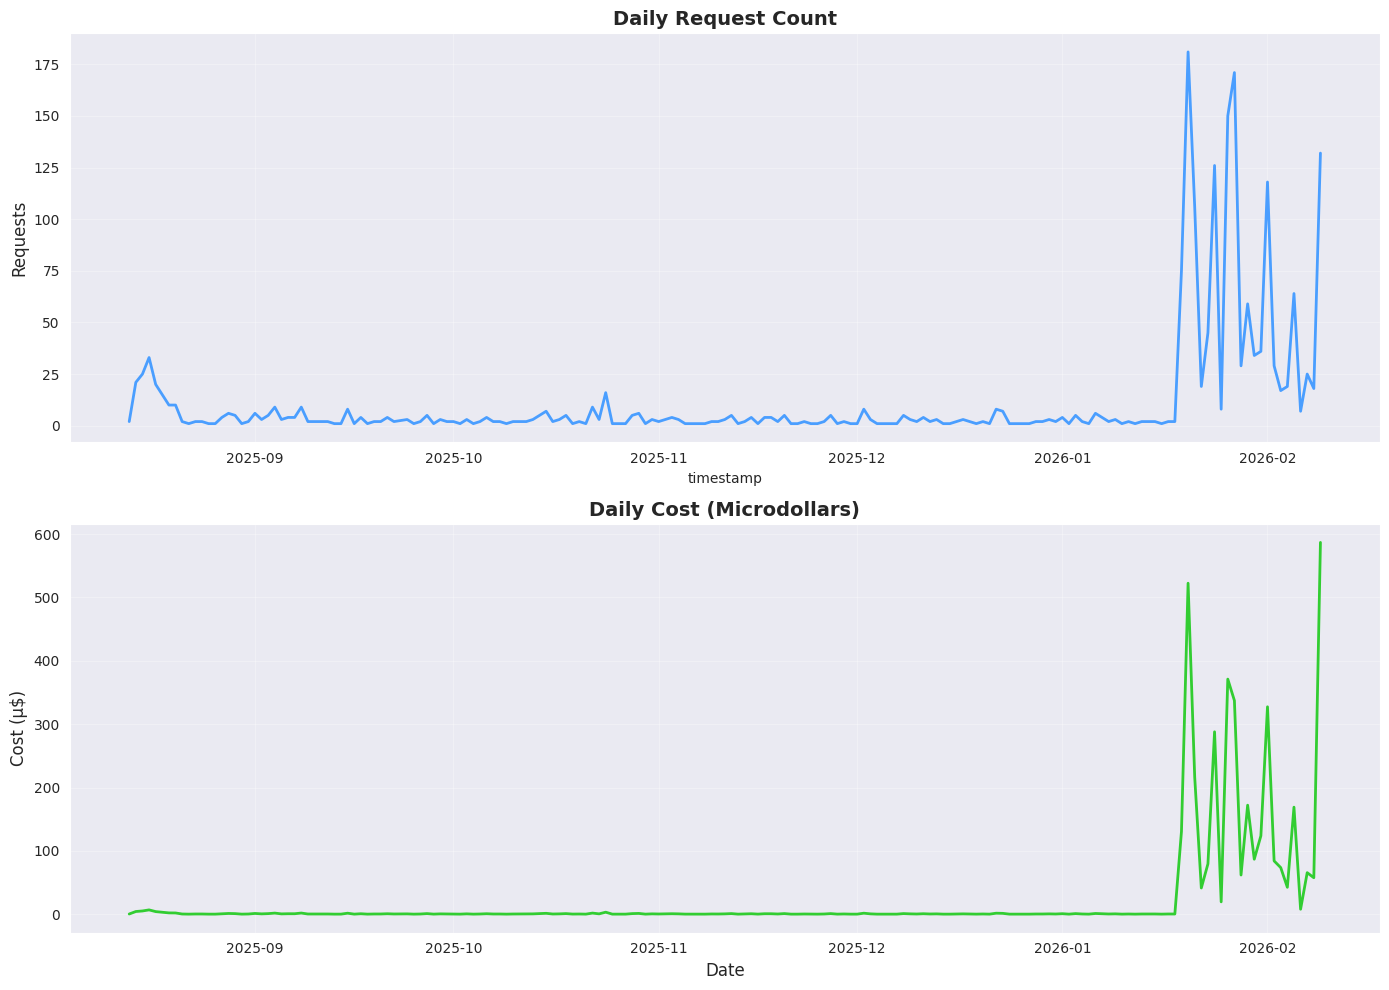


Peak day: 2026-01-20 with 181 requests


In [6]:
# Daily request counts
daily = df.groupby(df['timestamp'].dt.date).agg({
    'request_id': 'count',
    'duration_ms': 'mean',
    'cost_microdollars': 'sum'
}).rename(columns={'request_id': 'count'})

# Plot daily requests
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Request count
daily['count'].plot(ax=ax1, linewidth=2, color='#4a9eff')
ax1.set_title('Daily Request Count', fontsize=14, fontweight='bold')
ax1.set_ylabel('Requests', fontsize=12)
ax1.grid(True, alpha=0.3)

# Cost
daily['cost_microdollars'].plot(ax=ax2, linewidth=2, color='#32cd32')
ax2.set_title('Daily Cost (Microdollars)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cost (µ$)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPeak day: {daily['count'].idxmax()} with {daily['count'].max()} requests")

## 5. Path Analysis

In [7]:
# Top paths pie chart (exclude empty paths)
top_paths = df[df['path'] != '']['path'].value_counts().head(10)

if len(top_paths) > 0:
    fig = px.pie(
        values=top_paths.values,
        names=top_paths.index,
        title='Top 10 Endpoints by Request Count',
        hole=0.3
    )
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()
else:
    print("No path data available (all paths are empty)")


In [8]:
# Path performance comparison (exclude empty paths)
df_with_paths = df[df['path'] != '']

if len(df_with_paths) > 0:
    path_stats = df_with_paths.groupby('path').agg({
        'request_id': 'count',
        'duration_ms': 'mean',
        'cost_microdollars': 'sum'
    }).rename(columns={'request_id': 'count'})
    
    path_stats = path_stats.sort_values('count', ascending=False).head(10)
    
    print("Top 10 paths by request count:")
    print(path_stats)
    print(f"\nNote: {len(df) - len(df_with_paths)} records have no path (historical CloudWatch data)")
else:
    print("No path data available (all paths are empty)")


Top 10 paths by request count:
                                count  duration_ms  cost_microdollars
path                                                                 
/t3                                17  3647.531393         132.583662
/contents                          14   826.589357          26.908904
/favicon.ico                       14   276.860118          10.875103
/lambda-stats                       7   612.258358          10.328786
/gardencam                          4  7614.565015          64.254835
/gardencam/timelapse                3  1889.139255          12.407144
/gardencam/videos                   2  2442.723036          10.578033
/gardencam/timelapse/schedule       1   219.108582           0.656477
/gardencam/timelapse/timelapse      1   658.523798           1.571927

Note: 1948 records have no path (historical CloudWatch data)


## 6. Duration Analysis

/tmp/ipykernel_56367/2483683112.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




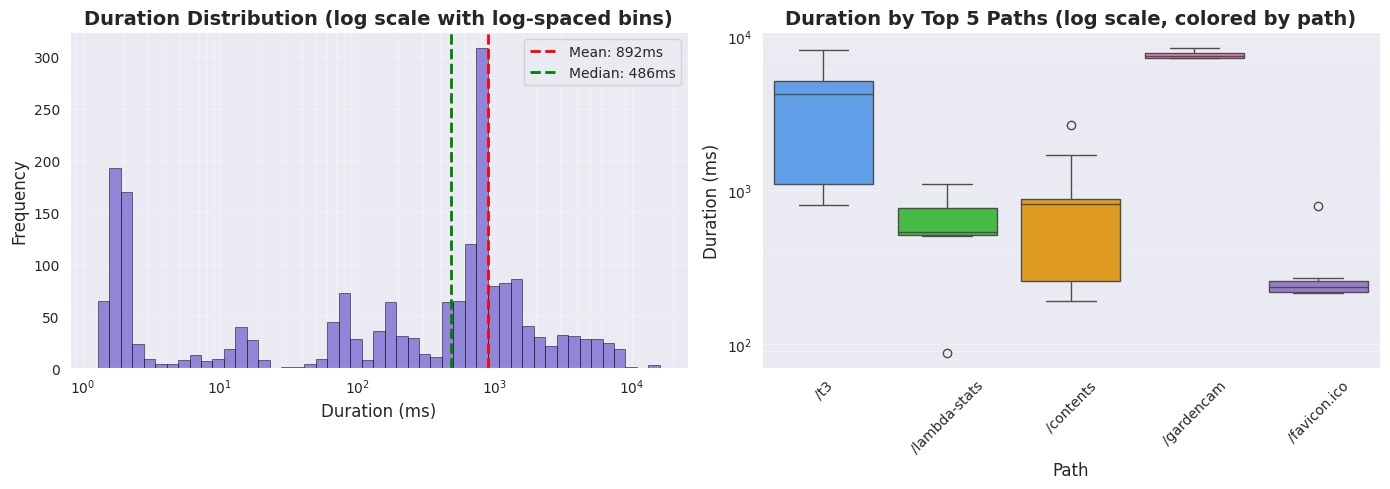


Duration stats:
  Min: 1.29ms
  Median: 486.44ms
  Mean: 892.37ms
  Max: 16074.69ms
  Range: 12461x


In [9]:
# Duration distribution
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with LOG-SCALED BINS for log axis
min_duration = df['duration_ms'].min()
max_duration = df['duration_ms'].max()

# Create logarithmically-spaced bins
log_bins = np.logspace(np.log10(min_duration), np.log10(max_duration), 50)

df['duration_ms'].hist(bins=log_bins, ax=ax1, color='#6a5acd', alpha=0.7, 
                       edgecolor='black', linewidth=0.5)
ax1.set_xscale('log')  # Log scale on axis
ax1.set_title('Duration Distribution (log scale with log-spaced bins)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Duration (ms)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)

# Add mean and median lines
mean_val = df['duration_ms'].mean()
median_val = df['duration_ms'].median()
ax1.axvline(mean_val, color='red', linestyle='--', linewidth=2,
           label=f'Mean: {mean_val:.0f}ms')
ax1.axvline(median_val, color='green', linestyle='--', linewidth=2,
           label=f'Median: {median_val:.0f}ms')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

# Box plot by path (top 5 paths with actual data) - COLORED BY PATH
df_with_paths = df[df['path'] != '']

if len(df_with_paths) > 0:
    top_5_paths = df_with_paths['path'].value_counts().head(5).index.tolist()
    df_top_paths = df_with_paths[df_with_paths['path'].isin(top_5_paths)]
    
    # Color palette for paths
    import seaborn as sns
    colors = ['#4a9eff', '#32cd32', '#ffa500', '#ff69b4', '#9370db']
    
    sns.boxplot(data=df_top_paths, x='path', y='duration_ms', ax=ax2, 
               palette=colors[:len(top_5_paths)])
    ax2.set_yscale('log')  # Log scale on Y-axis too
    ax2.set_title('Duration by Top 5 Paths (log scale, colored by path)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Path', fontsize=12)
    ax2.set_ylabel('Duration (ms)', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y', which='both')
else:
    ax2.text(0.5, 0.5, 'No path data available', 
            ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Duration by Top 5 Paths', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nDuration stats:")
print(f"  Min: {df['duration_ms'].min():.2f}ms")
print(f"  Median: {df['duration_ms'].median():.2f}ms")
print(f"  Mean: {df['duration_ms'].mean():.2f}ms")
print(f"  Max: {df['duration_ms'].max():.2f}ms")
print(f"  Range: {df['duration_ms'].max() / df['duration_ms'].min():.0f}x")


## 7. Cost Analysis

Monthly breakdown:
           requests   duration_ms  memory_limit_mb  cost_microdollars
timestamp                                                            
2025-08         163  6.636700e+02       122.070312          33.918596
2025-09          94  4.162300e+02       122.070312          19.626976
2025-10          99  4.826600e+02       122.070312          20.758961
2025-11          68  3.652100e+02       122.070312          14.325609
2025-12          76  3.409000e+02       122.070312          15.877309
2026-01        1082  1.129313e+06       122.070312        2460.251001
2026-02         429  6.629738e+05       122.070312        1414.842086


AWS FREE TIER COMPARISON

2025-08:
  Requests: 163.0 / 1,000,000 (0.016%)
  Compute: 0.1 / 400,000 GB-seconds (0.000%)
  💰 Actual cost: $0.00 (free tier covers everything)
  📊 Free tier remaining: 99.98%

2025-09:
  Requests: 94.0 / 1,000,000 (0.009%)
  Compute: 0.0 / 400,000 GB-seconds (0.000%)
  💰 Actual cost: $0.00 (free tier covers everything)

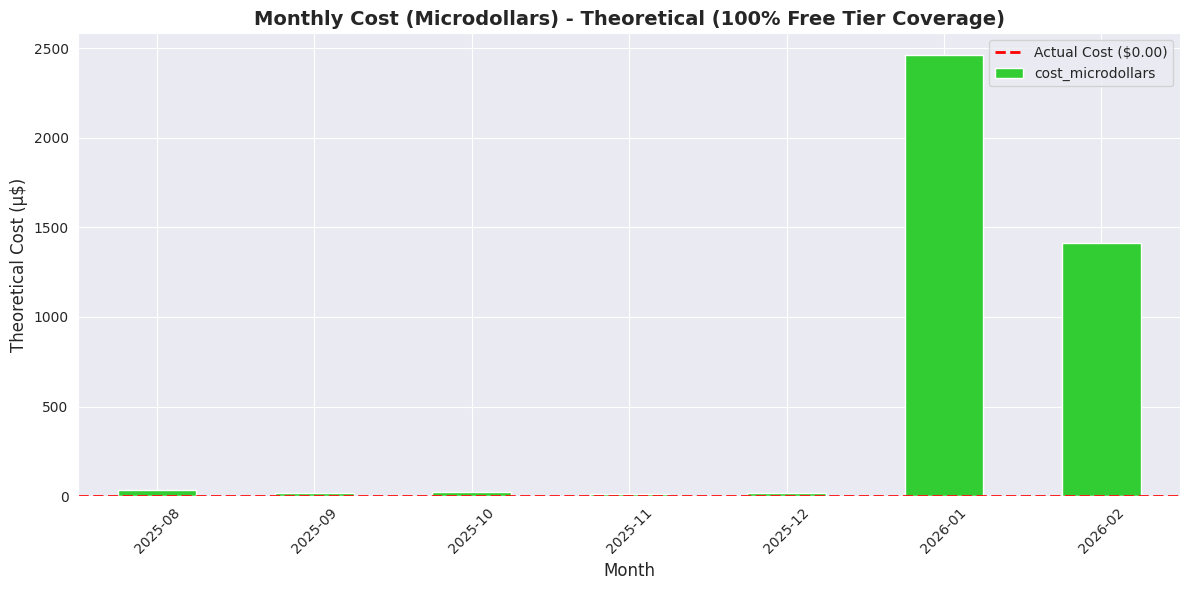

In [10]:
# Monthly cost breakdown with free tier comparison
monthly = df.groupby(df['timestamp'].dt.to_period('M')).agg({
    'request_id': 'count',
    'duration_ms': 'sum',
    'memory_limit_mb': 'first',  # Assuming constant memory
    'cost_microdollars': 'sum'
}).rename(columns={'request_id': 'requests'})

# AWS Lambda Free Tier (per month)
FREE_TIER_REQUESTS = 1_000_000  # 1M requests
FREE_TIER_GB_SECONDS = 400_000  # 400k GB-seconds

print("Monthly breakdown:")
print(monthly)
print()

# Calculate free tier usage for each month
print("\n" + "="*70)
print("AWS FREE TIER COMPARISON")
print("="*70)

for period, row in monthly.iterrows():
    requests = row['requests']
    duration_seconds = row['duration_ms'] / 1000
    memory_gb = row['memory_limit_mb'] / 1024 if 'memory_limit_mb' in row else 0.125
    gb_seconds = duration_seconds * memory_gb
    
    request_pct = (requests / FREE_TIER_REQUESTS) * 100
    compute_pct = (gb_seconds / FREE_TIER_GB_SECONDS) * 100
    
    print(f"\n{period}:")
    print(f"  Requests: {requests:,} / {FREE_TIER_REQUESTS:,} ({request_pct:.3f}%)")
    print(f"  Compute: {gb_seconds:.1f} / {FREE_TIER_GB_SECONDS:,} GB-seconds ({compute_pct:.3f}%)")
    print(f"  💰 Actual cost: $0.00 (free tier covers everything)")
    print(f"  📊 Free tier remaining: {100-max(request_pct, compute_pct):.2f}%")

# Overall summary
total_requests = monthly['requests'].sum()
total_duration = monthly['duration_ms'].sum() / 1000
avg_memory_gb = df['memory_limit_mb'].mean() / 1024 if 'memory_limit_mb' in df else 0.125
total_gb_seconds = total_duration * avg_memory_gb

print("\n" + "="*70)
print("TOTAL (All Months Combined)")
print("="*70)
print(f"Total requests: {total_requests:,}")
print(f"Total GB-seconds: {total_gb_seconds:.1f}")
print(f"\n🎉 You're using only {(total_requests/FREE_TIER_REQUESTS)*100:.3f}% of monthly request allowance")
print(f"🎉 You're using only {(total_gb_seconds/FREE_TIER_GB_SECONDS)*100:.3f}% of monthly compute allowance")
print(f"\n✅ ACTUAL MONTHLY COST: $0.00 (completely within free tier!)")
print(f"   Theoretical cost if no free tier: ${monthly['cost_microdollars'].sum()/1_000_000:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
monthly['cost_microdollars'].plot(kind='bar', ax=ax, color='#32cd32')
ax.set_title('Monthly Cost (Microdollars) - Theoretical (100% Free Tier Coverage)', 
            fontsize=14, fontweight='bold')
ax.set_ylabel('Theoretical Cost (µ$)', fontsize=12)
ax.set_xlabel('Month', fontsize=12)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Actual Cost ($0.00)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 8. Interactive Time Series (Plotly)

In [11]:
# Interactive Time Series - Histogram with selectable bucket sizes
import plotly.graph_objects as go

df_with_paths = df[df['path'] != ''].copy()

if len(df_with_paths) > 0:
    time_min = df_with_paths['timestamp'].min()
    time_max = df_with_paths['timestamp'].max()
    time_range_seconds = (time_max - time_min).total_seconds()
    time_range_days = time_range_seconds / 86400
    
    print(f"Full data range: {time_range_days:.1f} days ({time_min.date()} to {time_max.date()})")
    
    top_paths = df_with_paths['path'].value_counts().head(10).index.tolist()
    colors = ['#4a9eff', '#32cd32', '#ffa500', '#ff69b4', '#9370db',
              '#00ced1', '#ff6347', '#98fb98', '#dda0dd', '#f0e68c']
    
    def create_histogram(freq, label):
        """Create histogram with specific bucket size."""
        traces = []
        for idx, path in enumerate(top_paths):
            path_data = df_with_paths[df_with_paths['path'] == path].set_index('timestamp')
            bucketed = path_data.resample(freq).agg({'request_id': 'count'}).rename(columns={'request_id': 'count'})
            
            traces.append(go.Bar(
                x=bucketed.index,
                y=bucketed['count'],
                name=path,
                marker_color=colors[idx % len(colors)],
                hovertemplate='<b>%{fullData.name}</b><br>' +
                             'Time: %{x}<br>' +
                             'Requests: %{y}<br>' +
                             '<extra></extra>'
            ))
        
        num_buckets = int(time_range_seconds / {
            '1min': 60, '5min': 300, '15min': 900, '30min': 1800,
            '1H': 3600, '6H': 21600, '1D': 86400
        }.get(freq, 3600))
        
        return traces, num_buckets
    
    # Bucket size options (explicit time units)
    bucket_options = [
        ('1min', '1 minute'),
        ('5min', '5 minutes'),
        ('15min', '15 minutes'),
        ('30min', '30 minutes'),
        ('1H', '1 hour'),
        ('6H', '6 hours'),
        ('1D', '1 day')
    ]
    
    # Default: 1 hour
    default_freq = '1H'
    default_label = '1 hour'
    traces, num_buckets = create_histogram(default_freq, default_label)
    
    fig = go.Figure(data=traces)
    
    # Create buttons
    buttons = []
    for freq, label in bucket_options:
        new_traces, new_num = create_histogram(freq, label)
        
        buttons.append(dict(
            label=label,
            method='update',
            args=[{'x': [t.x for t in new_traces],
                   'y': [t.y for t in new_traces]},
                  {'title.text': f'Request Histogram - {label} buckets ({new_num} total)<br>' +
                                f'<sub>Click legend to filter | Drag to zoom | Fine granularity for detail</sub>',
                   'bargap': 0.05 if freq in ['1min', '5min'] else 0.1}]
        ))
    
    fig.update_layout(
        title=f'Request Histogram - {default_label} buckets ({num_buckets} total)<br>' +
              '<sub>Click legend to filter paths | Drag to zoom | Use buttons for finer detail</sub>',
        xaxis_title='Time',
        yaxis_title='Request Count',
        barmode='stack',
        hovermode='x unified',
        height=650,
        bargap=0.1,
        updatemenus=[
            dict(
                type='buttons',
                direction='left',
                buttons=buttons,
                pad={'r': 10, 't': 10},
                showactive=True,
                x=0.0,
                xanchor='left',
                y=1.15,
                yanchor='top',
                bgcolor='rgba(255, 255, 255, 0.8)',
                bordercolor='rgba(0, 0, 0, 0.2)',
                borderwidth=1
            )
        ],
        legend=dict(
            orientation='v',
            yanchor='top',
            y=1,
            xanchor='left',
            x=1.02,
            bgcolor='rgba(255, 255, 255, 0.8)',
            bordercolor='rgba(0, 0, 0, 0.2)',
            borderwidth=1
        ),
        xaxis=dict(
            rangeslider=dict(visible=True),
            type='date'
        ),
        template='plotly_white'
    )
    
    fig.show()
    
    print(f"\n📊 Available bucket sizes:")
    for freq, label in bucket_options:
        _, n = create_histogram(freq, label)
        print(f"  • {label:12} = {n:5,} buckets")
    
    print(f"\n💡 Tip: Use fine buckets (1min, 5min) for zoomed-in detail")
    print(f"   Use coarse buckets (1day) for overview")
else:
    print("No path data available")


Full data range: 13.3 days (2026-01-27 to 2026-02-09)


/tmp/ipykernel_56367/421214503.py:23: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.




📊 Available bucket sizes:
  • 1 minute     = 19,082 buckets
  • 5 minutes    = 3,816 buckets
  • 15 minutes   = 1,272 buckets
  • 30 minutes   =   636 buckets
  • 1 hour       =   318 buckets
  • 6 hours      =    53 buckets


  • 1 day        =    13 buckets

💡 Tip: Use fine buckets (1min, 5min) for zoomed-in detail
   Use coarse buckets (1day) for overview


/tmp/ipykernel_56367/421214503.py:23: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



## 9. Custom Analysis

Use this section for your own explorations!

In [12]:
# Example: Find the January spike
jan_spike = df[(df['timestamp'] >= '2026-01-19') & (df['timestamp'] <= '2026-01-27')]

print(f"January spike (Jan 19-27):")
print(f"Total requests: {len(jan_spike):,}")
print(f"Daily average: {len(jan_spike)/9:.0f}")
print(f"\nPath breakdown:")
print(jan_spike['path'].value_counts().head(10))

January spike (Jan 19-27):
Total requests: 710
Daily average: 79

Path breakdown:
path
    710
Name: count, dtype: int64


In [13]:
# Your analysis here...


## 10. Export Results

In [14]:
# Export summary to CSV
daily.to_csv('/home/tot/cv/daily_summary.csv')
print("✓ Exported daily summary to daily_summary.csv")

# Export full dataset
df.to_csv('/home/tot/cv/lambda_logs_full.csv', index=False)
print("✓ Exported full dataset to lambda_logs_full.csv")

✓ Exported daily summary to daily_summary.csv
✓ Exported full dataset to lambda_logs_full.csv
